# Evaluación del Sistema de Recomendación
Análisis exhaustivo del sistema de recomendación usando datos sintéticos con todas las combinaciones posibles de habilidades blandas.

## Objetivo
Evaluar la precisión, recall y F1-score del sistema de recomendación generando 128 variaciones de perfiles de habilidades blandas por cada una de las 24 carreras, dando un total de **3,072 usuarios sintéticos**.

## Metodología
1. **Generación de datos sintéticos:** Crear todas las 2^7 = 128 combinaciones posibles de 7 habilidades blandas
2. **Asignación de vectores:** Asignar vectores técnicos base de cada carrera
3. **Expansión a 76 dimensiones:** Concatenar habilidades técnicas (69d) con blandas (7d)
4. **Vectorización de ofertas:** Cargar y vectorizar ofertas laborales por carrera
5. **Cálculo de similitud:** Generar recomendaciones basadas en similitud de coseno
6. **Creación de verdad fundamental:** Definir criterios de relevancia basados en habilidades blandas
7. **Métricas de evaluación:** Calcular precisión, recall y F1-score.
8. **Análisis de resultados:** Agrupar por carrera y visualizar rendimiento.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

# Cargar datos preprocessados
with open('datos_procesados.pkl', 'rb') as f:
    datos = pickle.load(f)

tfidf_epn_69d = datos['tfidf_epn_69d']
grupos_bge_ngram = datos['grupos_bge_ngram']
habilidades_whitelist = datos['habilidades']

## 1. Generación de datos sintéticos
Se crean todos los 2^7 = 128 combinaciones posibles de las 7 habilidades blandas para cada una de las 24 carreras disponibles.

### Configuración de habilidades blandas
Las 7 dimensiones de habilidades blandas son:
1. **Gestión**
2. **Comunicación efectiva**
3. **Liderazgo**
4. **Trabajo en equipo**
5. **Ética profesional**
6. **Responsabilidad social**
7. **Aprendizaje autónomo**

Cada combinación binaria (0 o 1) representa si el usuario tiene desarrollada esa habilidad o no.

In [2]:
# Definición de habilidades blandas
habilidades_blandas_config = {
    'Gestión': 0,
    'Comunicación efectiva': 1,
    'Liderazgo': 2,
    'Trabajo en equipo': 3,
    'Ética profesional': 4,
    'Responsabilidad social': 5,
    'Aprendizaje autónomo': 6
}

# Definición de carreras disponibles (mapeo de tfidf_epn_69d.T)
carreras_disponibles = list(tfidf_epn_69d.T.index)

print(f"Total de habilidades blandas: {len(habilidades_blandas_config)}")
print(f"Combinaciones posibles por carrera: 2^{len(habilidades_blandas_config)} = {2**len(habilidades_blandas_config)}")
print(f"Total de carreras: {len(carreras_disponibles)}")
print(f"Total de usuarios sintéticos: {(2**len(habilidades_blandas_config)) * len(carreras_disponibles)}")
print(f"\nCarreras:")
for carrera in carreras_disponibles:
    print(f"  - {carrera}")

Total de habilidades blandas: 7
Combinaciones posibles por carrera: 2^7 = 128
Total de carreras: 24
Total de usuarios sintéticos: 3072

Carreras:
  - Licenciatura Administracion De Empresas
  - Ingenieria Agroindustria
  - Ingenieria Ambiental
  - Ciencias De Datos E Inteligencia Artificial
  - Ingenieria En Ciencias De La Computacion
  - Economia
  - Ingenieria En Electricidad
  - Ingenieria En Electronica Y Automatizacion
  - Fisica
  - Ingenieria En Geologia
  - Ingenieria De La Produccion
  - Matematica
  - Matematica Aplicada
  - Ingenieria En Materiales
  - Ingenieria En Mecanica
  - Ingenieria En Mecatronica
  - Ingenieria En Petroleos
  - Ingenieria Quimica
  - Ingenieria En Sistemas De Informacion
  - Ingenieria En Software
  - Ingenieria En Telecomunicacion De La Informacion
  - Ingenieria En Telecomunicaciones
  - Ingenieria Civil
  - Seguridad De Redes De Informacion


In [3]:
# Generar todas las combinaciones de habilidades blandas (2^7 = 128 combinaciones)
def generar_combinaciones_habilidades_blandas(num_habilidades=7):
    """
    Genera todas las 2^n combinaciones posibles de habilidades blandas.
    
    Returns:
        list: Lista de tuplas, donde cada tupla es una combinación binaria de 7 elementos
              Ejemplo: (0,0,0,0,0,0,0), (0,0,0,0,0,0,1), ..., (1,1,1,1,1,1,1)
    """
    return list(product([0, 1], repeat=num_habilidades))

# Generar combinaciones
combinaciones = generar_combinaciones_habilidades_blandas(len(habilidades_blandas_config))

print(f"Total de combinaciones generadas: {len(combinaciones)}")
print(f"\nPrimeras 10 combinaciones:")
for i, comb in enumerate(combinaciones[:10]):
    print(f"  {i}: {comb}")
print("  ...")
print(f"\nÚltimas 10 combinaciones:")
for i, comb in enumerate(combinaciones[-10:], start=len(combinaciones)-10):
    print(f"  {i}: {comb}")

Total de combinaciones generadas: 128

Primeras 10 combinaciones:
  0: (0, 0, 0, 0, 0, 0, 0)
  1: (0, 0, 0, 0, 0, 0, 1)
  2: (0, 0, 0, 0, 0, 1, 0)
  3: (0, 0, 0, 0, 0, 1, 1)
  4: (0, 0, 0, 0, 1, 0, 0)
  5: (0, 0, 0, 0, 1, 0, 1)
  6: (0, 0, 0, 0, 1, 1, 0)
  7: (0, 0, 0, 0, 1, 1, 1)
  8: (0, 0, 0, 1, 0, 0, 0)
  9: (0, 0, 0, 1, 0, 0, 1)
  ...

Últimas 10 combinaciones:
  118: (1, 1, 1, 0, 1, 1, 0)
  119: (1, 1, 1, 0, 1, 1, 1)
  120: (1, 1, 1, 1, 0, 0, 0)
  121: (1, 1, 1, 1, 0, 0, 1)
  122: (1, 1, 1, 1, 0, 1, 0)
  123: (1, 1, 1, 1, 0, 1, 1)
  124: (1, 1, 1, 1, 1, 0, 0)
  125: (1, 1, 1, 1, 1, 0, 1)
  126: (1, 1, 1, 1, 1, 1, 0)
  127: (1, 1, 1, 1, 1, 1, 1)


In [4]:
# Crear DataFrames de usuarios sintéticos
def crear_usuarios_sinteticos(carreras, combinaciones_blandas):
    """
    Crea un DataFrame con todos los usuarios sintéticos.
    
    Args:
        carreras: lista de nombres de carreras
        combinaciones_blandas: lista de tuplas con combinaciones (0,1) de habilidades
    
    Returns:
        pd.DataFrame: DataFrame con columnas de usuario_id, carrera, y 7 habilidades blandas
    """
    usuarios_data = []
    usuario_id = 0
    
    for carrera in carreras:
        for combinacion in combinaciones_blandas:
            usuario_data = {
                'usuario_id': usuario_id,
                'carrera': carrera,
                'Gestión': combinacion[0],
                'Comunicación efectiva': combinacion[1],
                'Liderazgo': combinacion[2],
                'Trabajo en equipo': combinacion[3],
                'Ética profesional': combinacion[4],
                'Responsabilidad social': combinacion[5],
                'Aprendizaje autónomo': combinacion[6]
            }
            usuarios_data.append(usuario_data)
            usuario_id += 1
    
    return pd.DataFrame(usuarios_data)

# Crear el DataFrame de usuarios sintéticos
df_usuarios_sinteticos = crear_usuarios_sinteticos(carreras_disponibles, combinaciones)

print(f"DataFrame de usuarios sintéticos creado")
print(f"Dimensiones: {df_usuarios_sinteticos.shape}")
print(f"  {df_usuarios_sinteticos.shape[0]} usuarios × {df_usuarios_sinteticos.shape[1]} columnas")

DataFrame de usuarios sintéticos creado
Dimensiones: (3072, 9)
  3072 usuarios × 9 columnas


In [5]:
print(f"\nPrimeros 5 usuarios:")
df_usuarios_sinteticos.head(5)


Primeros 5 usuarios:


,usuario_id,carrera,Gestión,Comunicación efectiva,Liderazgo,Trabajo en equipo,Ética profesional,Responsabilidad social,Aprendizaje autónomo
0,0,Licenciatura Administracion De Empresas,0,0,0,0,0,0,0
1,1,Licenciatura Administracion De Empresas,0,0,0,0,0,0,1
2,2,Licenciatura Administracion De Empresas,0,0,0,0,0,1,0
3,3,Licenciatura Administracion De Empresas,0,0,0,0,0,1,1
4,4,Licenciatura Administracion De Empresas,0,0,0,0,1,0,0


In [6]:
print(f"\nÚltimos 5 usuarios:")
df_usuarios_sinteticos.tail(5)


Últimos 5 usuarios:


,usuario_id,carrera,Gestión,Comunicación efectiva,Liderazgo,Trabajo en equipo,Ética profesional,Responsabilidad social,Aprendizaje autónomo
3067,3067,Seguridad De Redes De Informacion,1,1,1,1,0,1,1
3068,3068,Seguridad De Redes De Informacion,1,1,1,1,1,0,0
3069,3069,Seguridad De Redes De Informacion,1,1,1,1,1,0,1
3070,3070,Seguridad De Redes De Informacion,1,1,1,1,1,1,0
3071,3071,Seguridad De Redes De Informacion,1,1,1,1,1,1,1


## 2. Asignación de vectores técnicos base
A diferencia del cuaderno "08_Sistema_Recomendacion.ipynb" donde cada usuario personaliza su vector técnico según asignaturas relevantes, aquí todos los usuarios de una misma carrera tendrán el **mismo vector técnico base** de 69 dimensiones.

**Lógica:**
- Cada usuario sintético recibe el vector académico estándar de su carrera (sin personalización)
- El único factor de diferenciación entre los 128 usuarios de una carrera es su perfil de habilidades blandas (7 dimensiones)
- Esto permite evaluar cómo el sistema de recomendación responde exclusivamente a cambios en las habilidades blandas

In [7]:
# Todos los usuarios de una carrera reciben el mismo vector de 69 dimensiones

df_usuarios_sinteticos['Vector Academico 69d'] = df_usuarios_sinteticos['carrera'].apply(
    lambda carrera: tfidf_epn_69d.T.loc[carrera].values.copy()
)

print(f"Vectores académicos base asignados")
print(f"  Dimensión de cada vector: {df_usuarios_sinteticos['Vector Academico 69d'].iloc[0].shape[0]}")
print(f"  Todos los usuarios de una carrera comparten el mismo vector técnico")
# Verificar que todos los usuarios de una carrera tienen el mismo vector
carrera_test = df_usuarios_sinteticos['carrera'].iloc[0]
usuarios_misma_carrera = df_usuarios_sinteticos[df_usuarios_sinteticos['carrera'] == carrera_test]
vectores_unicos = len(set(
    tuple(usuario_vec) for usuario_vec in usuarios_misma_carrera['Vector Academico 69d']
))
print(f"\nTotla de data sintentica por carrera (ejemplo)")
print(f"  Carrera: {carrera_test}")
print(f"  Total de usuarios en esta carrera: {len(usuarios_misma_carrera)}")


Vectores académicos base asignados
  Dimensión de cada vector: 69
  Todos los usuarios de una carrera comparten el mismo vector técnico

Totla de data sintentica por carrera (ejemplo)
  Carrera: Licenciatura Administracion De Empresas
  Total de usuarios en esta carrera: 128


## 3. Incorporación de habilidades blandas
Se agregan las 7 dimensiones de habilidades blandas (binarias: 0 o 1) a partir de las columnas de combinaciones que ya existen en el DataFrame.
Las habilidades blandas se mantienen como valores binarios (sin normalización) para reflejar si cada usuario tiene desarrollada o no esa habilidad.

In [8]:
# Crear array de habilidades blandas para cada usuario
# Las 7 habilidades blandas ya están en el DataFrame como columnas binarias
cols_blandas = ['Gestión', 'Comunicación efectiva', 'Liderazgo', 'Trabajo en equipo', 
                'Ética profesional', 'Responsabilidad social', 'Aprendizaje autónomo']

def crear_array_habilidades_blandas(row):
    """
    Crea un array de 7 elementos (0.0 o 1.0) con las habilidades blandas del usuario
    """
    return np.array([
        float(row['Gestión']),
        float(row['Comunicación efectiva']),
        float(row['Liderazgo']),
        float(row['Trabajo en equipo']),
        float(row['Ética profesional']),
        float(row['Responsabilidad social']),
        float(row['Aprendizaje autónomo'])
    ])

df_usuarios_sinteticos['skills_blandas_array'] = df_usuarios_sinteticos.apply(
    crear_array_habilidades_blandas, 
    axis=1
)

print(f"Arrays de habilidades blandas creados")
print(f"Dimensión de cada array: {df_usuarios_sinteticos['skills_blandas_array'].iloc[0].shape[0]}")
print(f"\nEjemplos de habilidades blandas:")
for i in range(min(5, len(df_usuarios_sinteticos))):
    usuario = df_usuarios_sinteticos.iloc[i]
    blandas = usuario['skills_blandas_array']
    print(f"  Usuario {i}: {blandas}")

Arrays de habilidades blandas creados
Dimensión de cada array: 7

Ejemplos de habilidades blandas:
  Usuario 0: [0. 0. 0. 0. 0. 0. 0.]
  Usuario 1: [0. 0. 0. 0. 0. 0. 1.]
  Usuario 2: [0. 0. 0. 0. 0. 1. 0.]
  Usuario 3: [0. 0. 0. 0. 0. 1. 1.]
  Usuario 4: [0. 0. 0. 0. 1. 0. 0.]


## 4. Expansión del espacio vectorial a 76 dimensiones
Concatenación de los 69 vectores técnicos (base de cada carrera) con las 7 dimensiones de habilidades blandas.
Cada usuario sintético tendrá un vector de 76 dimensiones final: 69 técnicas (idénticas para todos de su carrera) + 7 blandas (varían según su combinación).

In [9]:
# Crear vectores 76-dimensionales (69 técnicas + 7 blandas)
def expandir_vector_76d(vector_69d, skills_blandas_array):
    """
    Expande un vector de 69 dimensiones técnicas con 7 dimensiones de habilidades blandas.
    
    Args:
        vector_69d: Array de 69 dimensiones (vector técnico base de la carrera)
        skills_blandas_array: Array de 7 elementos (0.0 o 1.0) con habilidades blandas
    
    Returns:
        Array de 76 dimensiones: [69 técnicas, 7 blandas]
    """
    return np.concatenate([vector_69d, skills_blandas_array])

# Aplicar expansión a todos los usuarios
df_usuarios_sinteticos['Vector Estudiante 76d'] = df_usuarios_sinteticos.apply(
    lambda row: expandir_vector_76d(
        row['Vector Academico 69d'],
        row['skills_blandas_array']
    ),
    axis=1
)

print(f"Vectores expandidos")
print(f"  Dimensión final de cada vector: {df_usuarios_sinteticos['Vector Estudiante 76d'].iloc[0].shape[0]}")
print(f"  Composición: 69 técnicas + 7 blandas")

# Mostrar ejemplos
print(f"\n{'='*100}")
print(f"EJEMPLOS DE VECTORES 76D")
print(f"{'='*100}")

# Mostrar 10 usuarios de la misma carrera con diferentes perfiles de habilidades blandas
carrera_ejemplo = df_usuarios_sinteticos['carrera'].iloc[0]
usuarios_ejemplo = df_usuarios_sinteticos[df_usuarios_sinteticos['carrera'] == carrera_ejemplo].head(5)

for idx, (index, usuario) in enumerate(usuarios_ejemplo.iterrows()):
    v = usuario['Vector Estudiante 76d']
    blandas_labels = ['Gestión', 'Comunicación', 'Liderazgo', 'Equipo', 'Ética', 'Social', 'Aprendizaje']
    
    print(f"\nUsuario {usuario['usuario_id']} | Carrera: {usuario['carrera']}")
    print(f"  Perfil de habilidades blandas: {v[69:76].astype(int)}")
    print(f"  Habilidades presentes: {', '.join([label for label, val in zip(blandas_labels, v[69:76]) if val > 0]) or 'Ninguna'}")
    print(f"  Vector técnico (primeras 5 dim): {np.round(v[:5], 4)}")
    print(f"  Vector blandas: {np.round(v[69:76], 1)}")

print(f"\n{'='*100}")
print(f"VERIFICACIÓN: Componentes técnicas idénticas dentro de la misma carrera")
print(f"{'='*100}")

# Verificar que las primeras 69 dimensiones son idénticas para usuarios de la misma carrera
usuarios_misma_carrera = df_usuarios_sinteticos[df_usuarios_sinteticos['carrera'] == carrera_ejemplo]
vector_tecnico_ref = usuarios_misma_carrera['Vector Estudiante 76d'].iloc[0][:69]

todos_iguales = all(
    np.allclose(usuario_vec[:69], vector_tecnico_ref) 
    for usuario_vec in usuarios_misma_carrera['Vector Estudiante 76d']
)

print(f"Carrera: {carrera_ejemplo}")
print(f"Total de usuarios en esta carrera: {len(usuarios_misma_carrera)}")
print(f"¿Componentes técnicas idénticas? {todos_iguales}" if todos_iguales else f"¿Componentes técnicas idénticas? {todos_iguales}")
print(f"¿Componentes blandas diferentes? {len(set(tuple(v[69:]) for v in usuarios_misma_carrera['Vector Estudiante 76d'])) > 1}")

Vectores expandidos
  Dimensión final de cada vector: 76
  Composición: 69 técnicas + 7 blandas

EJEMPLOS DE VECTORES 76D

Usuario 0 | Carrera: Licenciatura Administracion De Empresas
  Perfil de habilidades blandas: [0 0 0 0 0 0 0]
  Habilidades presentes: Ninguna
  Vector técnico (primeras 5 dim): [0.7612 0.     0.     0.     0.    ]
  Vector blandas: [0. 0. 0. 0. 0. 0. 0.]

Usuario 1 | Carrera: Licenciatura Administracion De Empresas
  Perfil de habilidades blandas: [0 0 0 0 0 0 1]
  Habilidades presentes: Aprendizaje
  Vector técnico (primeras 5 dim): [0.7612 0.     0.     0.     0.    ]
  Vector blandas: [0. 0. 0. 0. 0. 0. 1.]

Usuario 2 | Carrera: Licenciatura Administracion De Empresas
  Perfil de habilidades blandas: [0 0 0 0 0 1 0]
  Habilidades presentes: Social
  Vector técnico (primeras 5 dim): [0.7612 0.     0.     0.     0.    ]
  Vector blandas: [0. 0. 0. 0. 0. 1. 0.]

Usuario 3 | Carrera: Licenciatura Administracion De Empresas
  Perfil de habilidades blandas: [0 0 0 0 

Generación de un nuevo dataframe *df_usuarios_simulados* que tendrá las 76 dimensiones con los identificadores de las habilidades técnicas y blandas.

In [10]:
# Obtener nombres de las 69 dimensiones técnicas
nombres_tecnicas = list(tfidf_epn_69d.T.columns)

# Nombres de las 7 habilidades blandas
nombres_blandas = [
    'Gestión', 'Comunicación efectiva', 'Liderazgo', 'Trabajo en equipo',
    'Ética profesional', 'Responsabilidad social', 'Aprendizaje autónomo'
]

# Expandir los vectores en columnas separadas
vectores_expand = np.vstack(df_usuarios_sinteticos['Vector Estudiante 76d'].values)
df_usuarios_simulados = pd.DataFrame(vectores_expand, columns=nombres_tecnicas + nombres_blandas)

# Visualizar el nuevo DataFrame
df_usuarios_simulados.head()

,"administración de empresas, gestión de calidad, gestión de datos ...","agroindustria, agronomía","análisis de datos, análisis de materiales, análisis de sistemas ...","aprendizaje no supervisado, aprendizaje supervisado","arcgis, qgis",arquitectura de computadoras,"aws, wireless",balances de materia y energía,base de datos,buenas prácticas agrícolas,...,procesamiento de lenguaje natural,redes,redes neuronales,Gestión,Comunicación efectiva,Liderazgo,Trabajo en equipo,Ética profesional,Responsabilidad social,Aprendizaje autónomo
0,0.7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.7612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 5. Carga y vectorización de ofertas laborales (CON ETIQUETAS DE CARRERA)
Se cargan todas las ofertas laborales de cada carrera desde los archivos CSV. 
Cada oferta se **etiqueta con su carrera de origen**, lo que permitirá evaluar si el sistema de recomendación envía recomendaciones coherentes (verdaderos positivos) o incoherentes (falsos positivos).
A diferencia de la sección anterior, aquí se cargan **TODAS las ofertas de TODAS las carreras** para realizar evaluación global.

In [ ]:
# Mapeo de carreras EPN a archivos CSV
carrera_to_csv = {
    'Ingenieria En Ciencias De La Computacion': 'todas_las_plataformas/Computación/Computación_Merged.csv',
    'Ingenieria Agroindustria': 'todas_las_plataformas/Agroindustria/Agroindustria_Merged.csv',
    'Licenciatura Administracion De Empresas': 'todas_las_plataformas/Administración_de_Empresas/Administración_de_Empresas_Merged.csv',
    'Ingenieria Ambiental': 'todas_las_plataformas/Ingeniería_Ambiental/Ingeniería_Ambiental_Merged.csv',
    'Economia': 'todas_las_plataformas/Economía/Economía_Merged.csv',
    'Ingenieria En Electricidad': 'todas_las_plataformas/Electricidad/Electricidad_Merged.csv',
    'Ingenieria En Electronica Y Automatizacion': 'todas_las_plataformas/Electrónica_y_Automatización/Electrónica_y_Automatización_Merged.csv',
    'Fisica': 'todas_las_plataformas/Física/Física_Merged.csv',
    'Ingenieria En Geologia': 'todas_las_plataformas/Geología/Geología_Merged.csv',
    'Ingenieria De La Produccion': 'todas_las_plataformas/Ingeniería_de_la_Producción/Ingeniería_de_la_Producción_Merged.csv',
    'Ingenieria En Materiales': 'todas_las_plataformas/Materiales/Materiales_Merged.csv',
    'Ingenieria En Mecanica': 'todas_las_plataformas/Mecánica/Mecánica_Merged.csv',
    'Ingenieria En Mecatronica': 'todas_las_plataformas/Mecatrónica/Mecatrónica_Merged.csv',
    'Ingenieria En Petroleos': 'todas_las_plataformas/Petróleos/Petróleos_Merged.csv',
    'Ingenieria Quimica': 'todas_las_plataformas/Ingeniería_Química/Ingeniería_Química_Merged.csv',
    'Ingenieria En Telecomunicaciones': 'todas_las_plataformas/Telecomunicaciones/Telecomunicaciones_Merged.csv',
    'Ingenieria Civil': 'todas_las_plataformas/Ingeniería_Civil/Ingeniería_Civil_Merged.csv',
    'Matematica': 'todas_las_plataformas/Matemática/Matemática_Merged.csv',
    'Matematica Aplicada': 'todas_las_plataformas/Matemática_Aplicada/Matemática_Aplicada_Merged.csv',
    'Ingenieria En Software': 'todas_las_plataformas/Software/Software_Merged.csv',
    'Ciencias De Datos E Inteligencia Artificial': [
        'todas_las_plataformas/Inteligencia_Artificial/Inteligencia_Artificial_Merged.csv',
        'todas_las_plataformas/Ciencia_de_Datos/Ciencia_de_Datos_Merged.csv'
    ],
    'Ingenieria En Sistemas De Informacion': 'todas_las_plataformas/Sistemas_de_Información/Sistemas_de_Información_Merged.csv',
}

print(f"Mapeo de carreras a archivos CSV: {len(carrera_to_csv)} carreras disponibles")

Mapeo de carreras a archivos CSV: 22 carreras disponibles


In [12]:
# Función para cargar y vectorizar ofertas de una carrera
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def cargar_y_vectorizar_ofertas_carrera(ruta_csv, carrera_etiqueta):
    """
    Carga ofertas de uno o múltiples CSVs y las vectoriza a 76 dimensiones, CON ETIQUETA DE CARRERA.
    
    Args:
        ruta_csv: Ruta al archivo CSV de ofertas (str) o lista de rutas (list)
        carrera_etiqueta: Etiqueta (carrera) a asignar a estas ofertas
    
    Returns:
        tuple: (DataFrame con vectores 76d y metadatos, list de etiquetas de carrera)
    """
    # Convertir ruta_csv a lista si es string
    rutas = ruta_csv if isinstance(ruta_csv, list) else [ruta_csv]
    
    # Verificar que todas las rutas existen
    for ruta in rutas:
        if not os.path.exists(ruta):
            return None, None
    
    try:
        # Cargar y concatenar todos los CSVs
        df_ofertas_list = []
        for ruta in rutas:
            df = pd.read_csv(ruta, dtype=str)
            df_ofertas_list.append(df)
        df_ofertas = pd.concat(df_ofertas_list, ignore_index=True)
        
        if not {'skills', 'description', 'EURACE_skills'}.issubset(df_ofertas.columns):
            return None, None
        
        # Vectorizar habilidades técnicas (69d)
        textos = df_ofertas[['skills', 'description']].fillna('').agg(' '.join, axis=1).str.lower().tolist()
        
        vectorizer = CountVectorizer(vocabulary=habilidades_whitelist, analyzer='word', 
                                     ngram_range=(1, 5), lowercase=True)
        X = vectorizer.fit_transform(textos)
        matriz_td = pd.DataFrame(X.T.toarray(), index=vectorizer.get_feature_names_out())
        
        # Agrupar por dimensiones BGE
        matriz_69d = pd.DataFrame(0, index=grupos_bge_ngram.keys(), columns=range(len(textos)))
        for label, terms in grupos_bge_ngram.items():
            terms_validos = [t for t in terms if t in matriz_td.index]
            if terms_validos:
                matriz_69d.loc[label] = matriz_td.loc[terms_validos].sum(axis=0)
        
        # Aplicar TF-IDF
        tfidf = TfidfTransformer(norm='l2')
        tfidf_69d = tfidf.fit_transform(matriz_69d.values)
        tfidf_69d_df = pd.DataFrame(tfidf_69d.toarray(), 
                                     index=matriz_69d.index, 
                                     columns=matriz_69d.columns).T
        
        # Expandir a 76 dimensiones: agregar habilidades blandas desde EURACE_skills
        vectores_76d = []
        for idx in range(len(df_ofertas)):
            vector_tecnico = tfidf_69d_df.iloc[idx].values
            eurace_text = str(df_ofertas.iloc[idx]['EURACE_skills']).lower()
            
            # Detectar habilidades blandas en EURACE_skills
            vector_blandas = np.array([
                1.0 if 'gestion' in eurace_text else 0.0,
                1.0 if 'comunicacion' in eurace_text else 0.0,
                1.0 if 'liderazgo' in eurace_text else 0.0,
                1.0 if 'equipo' in eurace_text else 0.0,
                1.0 if 'etica' in eurace_text else 0.0,
                1.0 if 'responsabilidad' in eurace_text else 0.0,
                1.0 if 'aprendizaje' in eurace_text else 0.0,
            ])
            
            vector_76d = np.concatenate([vector_tecnico, vector_blandas])
            vectores_76d.append(vector_76d)
        
        # Crear DataFrame con vectores 76d
        df_vectores_76d = pd.DataFrame(vectores_76d)
        df_vectores_76d.columns = list(range(76))
        df_vectores_76d['carrera_etiqueta'] = carrera_etiqueta  # ETIQUETA DE CARRERA
        
        return df_vectores_76d, df_ofertas
    
    except Exception as e:
        print(f"  Error al procesar {ruta_csv}: {str(e)}")
        return None, None

print(f"Función de carga y vectorización de ofertas cargada")

Función de carga y vectorización de ofertas cargada


In [ ]:
# Cargar y vectorizar TODAS las ofertas de TODAS las carreras
print("Cargando ofertas laborales de TODAS las carreras\n")

lista_ofertas_todas = []
carreras_con_datos = 0
carreras_sin_datos_list = []

for carrera in carreras_disponibles:
    if carrera not in carrera_to_csv:
        carreras_sin_datos_list.append(carrera)
        continue
    
    ruta = carrera_to_csv[carrera]
    print(f"  {carrera}...", end=" ")
    
    df_vectores_76d, df_ofertas_original = cargar_y_vectorizar_ofertas_carrera(ruta, carrera)
    
    if df_vectores_76d is not None and not df_vectores_76d.empty:
        lista_ofertas_todas.append(df_vectores_76d)
        print(f" ({len(df_vectores_76d)} ofertas)")
        carreras_con_datos += 1
    else:
        print(f"✗ (Sin datos o error)")
        carreras_sin_datos_list.append(carrera)

# Concatenar todas las ofertas en un único DataFrame
df_todas_ofertas = pd.concat(lista_ofertas_todas, ignore_index=True)

# Renombrar columnas: 0-68 -> dimensiones técnicas, 69-75 -> habilidades blandas
nombres_dimensiones = list(tfidf_epn_69d.T.columns) + [
    'Gestión', 'Comunicación', 'Liderazgo', 'Trabajo en Equipo', 
    'Ética Profesional', 'Responsabilidad Social', 'Aprendizaje Autónomo'
]
rename_dict = {i: nombres_dimensiones[i] for i in range(76)}
df_todas_ofertas = df_todas_ofertas.rename(columns=rename_dict)

print(f"\n Total de ofertas cargadas: {len(df_todas_ofertas)}")
print(f" Carreras con datos: {carreras_con_datos}")
print(f" Carreras sin datos: {len(carreras_sin_datos_list)}")
print(f"\nDimensiones del DataFrame de ofertas: {df_todas_ofertas.shape}")
print(f"Primeras 3 dimensiones técnicas: {nombres_dimensiones[:3]}")
print(f"Últimas 3 habilidades blandas: {nombres_dimensiones[-3:]}")

Cargando ofertas laborales de TODAS las carreras...

  Licenciatura Administracion De Empresas...  (5220 ofertas)
  Ingenieria Agroindustria...  (1688 ofertas)
  Ingenieria Ambiental...  (3295 ofertas)
  Ciencias De Datos E Inteligencia Artificial...  (11641 ofertas)
  Ingenieria En Ciencias De La Computacion...  (4101 ofertas)
  Economia...  (2506 ofertas)
  Ingenieria En Electricidad...  (2066 ofertas)
  Ingenieria En Electronica Y Automatizacion...  (6349 ofertas)
  Fisica...  (1614 ofertas)
  Ingenieria En Geologia...  (1074 ofertas)
  Ingenieria De La Produccion...  (4503 ofertas)
  Matematica...  (399 ofertas)
  Matematica Aplicada...  (383 ofertas)
  Ingenieria En Materiales...  (2127 ofertas)
  Ingenieria En Mecanica...  (1633 ofertas)
  Ingenieria En Mecatronica...  (1338 ofertas)
  Ingenieria En Petroleos...  (1551 ofertas)
  Ingenieria Quimica...  (1148 ofertas)
  Ingenieria En Sistemas De Informacion...  (6157 ofertas)
  Ingenieria En Software...  (5873 ofertas)
  Ingenieri

In [14]:
df_todas_ofertas.head()

,"administración de empresas, gestión de calidad, gestión de datos ...","agroindustria, agronomía","análisis de datos, análisis de materiales, análisis de sistemas ...","aprendizaje no supervisado, aprendizaje supervisado","arcgis, qgis",arquitectura de computadoras,"aws, wireless",balances de materia y energía,base de datos,buenas prácticas agrícolas,...,redes,redes neuronales,Gestión,Comunicación,Liderazgo,Trabajo en Equipo,Ética Profesional,Responsabilidad Social,Aprendizaje Autónomo,carrera_etiqueta
0,0.058963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Licenciatura Administracion De Empresas
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Licenciatura Administracion De Empresas
2,0.058963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Licenciatura Administracion De Empresas
3,0.176889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Licenciatura Administracion De Empresas
4,0.049991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273945,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Licenciatura Administracion De Empresas


## 6. Sistema de recomendación global (comparación con TODAS las ofertas)
A diferencia de los sistemas anteriores que comparaban un usuario con ofertas de su misma carrera,
aquí cada usuario sintético se compara con **TODAS las ofertas de TODAS las carreras**.
Esto permite evaluar si el sistema:
- **Verdadero Positivo (TP):** Recomienda ofertas de su propia carrera (coherente)
- **Falso Positivo (FP):** Recomienda ofertas de otras carreras (incoherente)
- **Verdadero Negativo (TN):** No recomienda ofertas de otras carreras (correcto)
- **Falso Negativo (FN):** No recomienda ofertas de su carrera que debería recomendar

In [15]:
# Sistema de recomendación 
def obtener_recomendaciones_mejoradas(vector_usuario_76d, carrera_usuario, top_n, alpha):
    """
    Retorna top-N ofertas ordenadas por score = similitud de coseno + alpha*(misma_carrera).
    No realiza filtrado duro por carrera; mezcla según similitud y un refuerzo suave.
    """
    # Vectores de todas las ofertas (76d)
    vectores_todas = df_todas_ofertas.iloc[:, :76].values

    # Similitud con todas las ofertas
    sims = cosine_similarity([vector_usuario_76d], vectores_todas)[0]

    # Refuerzo suave si pertenece a la misma carrera
    mask_misma = (df_todas_ofertas['carrera_etiqueta'] == carrera_usuario).values.astype(float)
    score = sims + alpha * mask_misma

    # Ordenar por score y devolver top-N
    indices_ordenados = np.argsort(score)[::-1][:top_n]
    return indices_ordenados.tolist()

print("Generando recomendaciones con ranking mezclado...")
print(f"Total de usuarios: {len(df_usuarios_sinteticos)}\n")

df_usuarios_sinteticos['recomendaciones_indices_globales'] = df_usuarios_sinteticos.apply(
    lambda row: obtener_recomendaciones_mejoradas(
        row['Vector Estudiante 76d'],
        row['carrera'],
        top_n=5,
        alpha=0.11
    ),
    axis=1
)

print("  Recomendaciones generadas para todos los usuarios")
print("\nEjemplo para usuario 0:")
print(f"  Carrera del usuario: {df_usuarios_sinteticos.iloc[0]['carrera']}")
print("  Carreras de las ofertas recomendadas:")
for idx in df_usuarios_sinteticos.iloc[0]['recomendaciones_indices_globales'][:10]:
    carrera_oferta = df_todas_ofertas.iloc[idx]['carrera_etiqueta']
    es_correcta = "-" if carrera_oferta == df_usuarios_sinteticos.iloc[0]['carrera'] else "✗"
    print(f"    {es_correcta} {carrera_oferta}")

Generando recomendaciones con ranking mezclado...
Total de usuarios: 3072

  Recomendaciones generadas para todos los usuarios

Ejemplo para usuario 0:
  Carrera del usuario: Licenciatura Administracion De Empresas
  Carreras de las ofertas recomendadas:
    - Licenciatura Administracion De Empresas
    - Licenciatura Administracion De Empresas
    - Licenciatura Administracion De Empresas
    - Licenciatura Administracion De Empresas
    - Licenciatura Administracion De Empresas


## 7. Creación de Ground Truth y Clasificación de Recomendaciones
Se evalúa cada recomendación:
- **Verdadero Positivo (TP):** La oferta es de la misma carrera del usuario → Recomendación correcta
- **Falso Positivo (FP):** La oferta es de diferente carrera del usuario → Recomendación incorrecta

Esto permite calcular Precisión = TP / (TP + FP) para cada usuario.

In [16]:
# Función para evaluar si una recomendación es correcta (TP) o incorrecta (FP)
def evaluar_recomendaciones(carrera_usuario, indices_recomendaciones):
    """
    Evalúa cada recomendación comparando la carrera del usuario con la carrera de la oferta.
    
    Returns:
        dict: Contiene 'TP' (recomendaciones correctas) y 'FP' (recomendaciones incorrectas)
    """
    tp = 0  # Verdaderos Positivos (oferta de su carrera)
    fp = 0  # Falsos Positivos (oferta de otra carrera)
    
    for idx_oferta in indices_recomendaciones:
        carrera_oferta = df_todas_ofertas.iloc[idx_oferta]['carrera_etiqueta']
        
        if carrera_oferta == carrera_usuario:
            tp += 1
        else:
            fp += 1
    
    return {'TP': tp, 'FP': fp}

# Evaluar todas las recomendaciones
print("Evaluando recomendaciones (Verdaderos Positivos vs Falsos Positivos)...\n")

df_usuarios_sinteticos['evaluacion_recomendaciones'] = df_usuarios_sinteticos.apply(
    lambda row: evaluar_recomendaciones(
        row['carrera'],
        row['recomendaciones_indices_globales']
    ),
    axis=1
)

# Extraer TP y FP
df_usuarios_sinteticos['TP'] = df_usuarios_sinteticos['evaluacion_recomendaciones'].apply(lambda x: x['TP'])
df_usuarios_sinteticos['FP'] = df_usuarios_sinteticos['evaluacion_recomendaciones'].apply(lambda x: x['FP'])

print(f"  Evaluación completada para {len(df_usuarios_sinteticos)} usuarios")
print(f"\nEjemplos de evaluación:")
for i in range(min(5, len(df_usuarios_sinteticos))):
    usuario = df_usuarios_sinteticos.iloc[i]
    print(f"  Usuario {i} ({usuario['carrera']}): TP={usuario['TP']}, FP={usuario['FP']}")

Evaluando recomendaciones (Verdaderos Positivos vs Falsos Positivos)...

  Evaluación completada para 3072 usuarios

Ejemplos de evaluación:
  Usuario 0 (Licenciatura Administracion De Empresas): TP=5, FP=0
  Usuario 1 (Licenciatura Administracion De Empresas): TP=2, FP=3
  Usuario 2 (Licenciatura Administracion De Empresas): TP=3, FP=2
  Usuario 3 (Licenciatura Administracion De Empresas): TP=3, FP=2
  Usuario 4 (Licenciatura Administracion De Empresas): TP=5, FP=0


## 8. Cálculo de Métricas de Evaluación por Usuario
Se calculan para cada usuario:
- **Precisión:** TP / (TP + FP) → ¿Qué proporción de recomendaciones fueron correctas?
- **Recall:** TP / (TP + FN) → En nuestro caso simplificado, evaluamos con top-5, así que FN es implícito
- **F1-Score:** Media armónica de precisión y recall

Notas:
- Precisión alta significa que el sistema no recomienda ofertas de carreras incorrectas
- Con top-5 recomendaciones, esperamos que Precisión sea cercana a 1.0 si funciona bien

In [17]:
# Calcular métricas para cada usuario

def calcular_metricas_por_usuario(tp, fp, k, num_relevantes):
    """
    Calcula Precisión@k, Recall@k y F1-Score para un usuario.

    Args:
        tp: Verdaderos Positivos (ofertas correctas dentro de las k recomendaciones)
        fp: Falsos Positivos (ofertas incorrectas dentro de las k recomendaciones)
        k:  Número de recomendaciones emitidas para el usuario (len(lista_top_k))
        num_relevantes: Número total de ofertas relevantes en el catálogo
                        (aquí, ofertas de la misma carrera del usuario)

    Returns:
        dict: {precision, recall, f1_score}
    """
    precision = (tp / k) if k > 0 else 0.0
    recall = (tp / num_relevantes) if num_relevantes > 0 else 0.0

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

print("Calculando métricas (Precisión@k, Recall@k, F1-Score) para cada usuario...\n")

# Derivar k por usuario (longitud real de la lista de recomendaciones)
df_usuarios_sinteticos['k_rec'] = df_usuarios_sinteticos['recomendaciones_indices_globales'].apply(len)

# Número total de relevantes por usuario (total de ofertas de su misma carrera en el catálogo)
conteo_relevantes_por_carrera = df_todas_ofertas['carrera_etiqueta'].value_counts().to_dict()
df_usuarios_sinteticos['num_relevantes'] = df_usuarios_sinteticos['carrera'].map(lambda c: int(conteo_relevantes_por_carrera.get(c, 0)))

# Aplicar cálculo a todos los usuarios
metricas_usuarios = df_usuarios_sinteticos.apply(
    lambda row: calcular_metricas_por_usuario(
        row['TP'], row['FP'], row['k_rec'], row['num_relevantes']
    ),
    axis=1
)

# Expandir métricas en columnas
df_usuarios_sinteticos['precision'] = metricas_usuarios.apply(lambda x: x['precision'])
df_usuarios_sinteticos['recall'] = metricas_usuarios.apply(lambda x: x['recall'])
df_usuarios_sinteticos['f1_score'] = metricas_usuarios.apply(lambda x: x['f1_score'])

print(f"✓ Métricas calculadas para {len(df_usuarios_sinteticos)} usuarios")
print(f"\nEjemplos de métricas (primeros 10 usuarios):")
print(df_usuarios_sinteticos[['usuario_id', 'carrera', 'TP', 'FP', 'precision', 'recall', 'f1_score']].head(10))

Calculando métricas (Precisión@k, Recall@k, F1-Score) para cada usuario...

✓ Métricas calculadas para 3072 usuarios

Ejemplos de métricas (primeros 10 usuarios):
   usuario_id                                  carrera  TP  FP  precision  \
0           0  Licenciatura Administracion De Empresas   5   0        1.0   
1           1  Licenciatura Administracion De Empresas   2   3        0.4   
2           2  Licenciatura Administracion De Empresas   3   2        0.6   
3           3  Licenciatura Administracion De Empresas   3   2        0.6   
4           4  Licenciatura Administracion De Empresas   5   0        1.0   
5           5  Licenciatura Administracion De Empresas   2   3        0.4   
6           6  Licenciatura Administracion De Empresas   4   1        0.8   
7           7  Licenciatura Administracion De Empresas   3   2        0.6   
8           8  Licenciatura Administracion De Empresas   4   1        0.8   
9           9  Licenciatura Administracion De Empresas   5   0     

## 9. Análisis Agregado por Carrera
Se agrupan las métricas por carrera para identificar cuáles carreras tienen mejor rendimiento del sistema de recomendación.

In [18]:
# Agregación simplificada de métricas por carrera
print("="*100)
print("MÉTRICAS AGREGADAS POR CARRERA")
print("="*100 + "\n")

df_metricas_por_carrera = df_usuarios_sinteticos.groupby('carrera').agg({
    'TP': ['sum', 'mean'],
    'FP': ['sum', 'mean'],
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean',
    'usuario_id': 'count'
}).round(4)

df_metricas_por_carrera.columns = ['TP_Total', 'TP_Media', 'FP_Total', 'FP_Media', 
                                   'Precisión', 'Recall', 'F1-Score', 'Num_Usuarios']
print(df_metricas_por_carrera.to_string())

# Estadísticas globales
print("\n" + "="*100)
print("RESUMEN GLOBAL DEL SISTEMA DE RECOMENDACIÓN")
print("="*100 + "\n")

num_usuarios = len(df_usuarios_sinteticos)
num_carreras = len(df_metricas_por_carrera)

total_recomendaciones = int(df_usuarios_sinteticos['k_rec'].sum())

total_tp = int(df_usuarios_sinteticos['TP'].sum())
total_fp = int(df_usuarios_sinteticos['FP'].sum())

print(f"Total de usuarios evaluados:        {num_usuarios}")
print(f"Total de carreras:                  {num_carreras}")
print(f"Total de recomendaciones:           {total_recomendaciones}")
print(f"Verdaderos Positivos (TP):          {total_tp} ({(total_tp/total_recomendaciones*100 if total_recomendaciones>0 else 0):.2f}%)")
print(f"Falsos Positivos (FP):              {total_fp} ({(total_fp/total_recomendaciones*100 if total_recomendaciones>0 else 0):.2f}%)")

precision_global = df_usuarios_sinteticos['precision'].mean()
recall_global = df_usuarios_sinteticos['recall'].mean()
f1_global = df_usuarios_sinteticos['f1_score'].mean()

print(f"\nMÉTRICAS GLOBALES:")
print(f"  Precisión Media:  {precision_global:.4f}")
print(f"  Recall Medio:     {recall_global:.4f}")
print(f"  F1-Score Medio:   {f1_global:.4f}")

print("\n" + "="*100)

MÉTRICAS AGREGADAS POR CARRERA

                                                  TP_Total  TP_Media  FP_Total  FP_Media  Precisión  Recall  F1-Score  Num_Usuarios
carrera                                                                                                                            
Ciencias De Datos E Inteligencia Artificial            631    4.9297         9    0.0703     0.9859  0.0004    0.0008           128
Economia                                               445    3.4766       195    1.5234     0.6953  0.0014    0.0028           128
Fisica                                                 216    1.6875       424    3.3125     0.3375  0.0010    0.0021           128
Ingenieria Agroindustria                               388    3.0312       252    1.9688     0.6062  0.0018    0.0036           128
Ingenieria Ambiental                                   534    4.1719       106    0.8281     0.8344  0.0013    0.0025           128
Ingenieria Civil                            

## 10. Matriz de Confusión y Análisis Detallado
Se construye una matriz de confusión global que muestra cómo se clasifican las recomendaciones:

Matriz de Confusión Binaria (2x2):



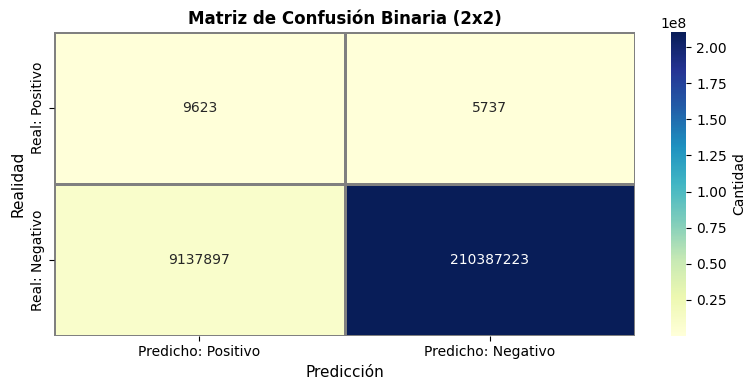

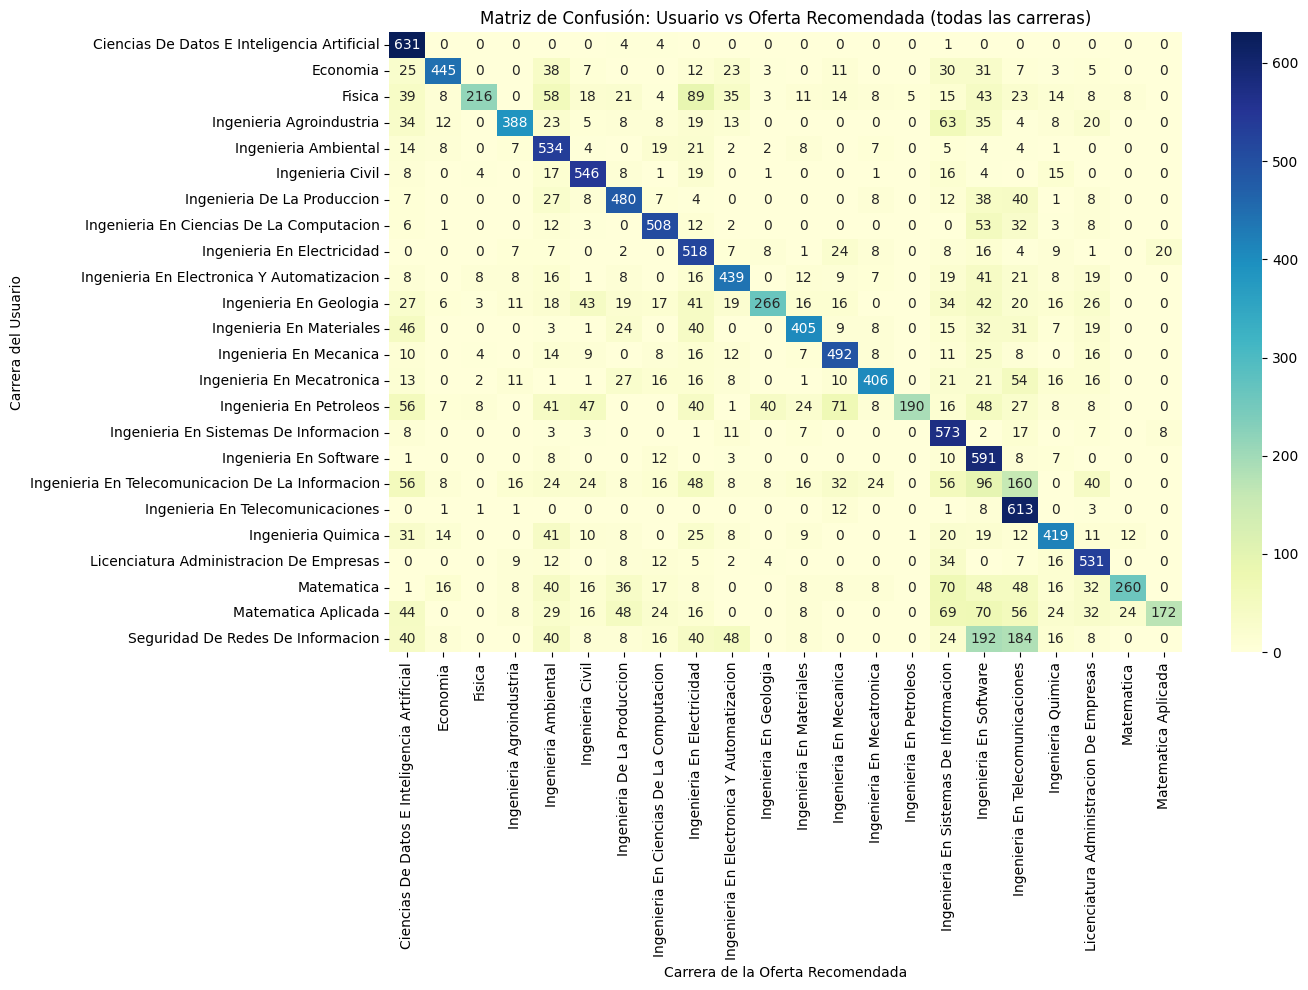

,Recomendaciones_Correctas,Total_Recomendaciones,Porcentaje_Acierto
carrera_usuario,,,
Ciencias De Datos E Inteligencia Artificial,631,640,98.59%
Economia,445,640,69.53%
Fisica,216,640,33.75%
Ingenieria Agroindustria,388,640,60.62%
Ingenieria Ambiental,534,640,83.44%
Ingenieria Civil,546,640,85.31%
Ingenieria De La Produccion,480,640,75.00%
Ingenieria En Ciencias De La Computacion,508,640,79.38%
Ingenieria En Electricidad,518,640,80.94%


In [19]:
# Matriz de confusión binaria (2x2) y matriz detallada para todas las carreras
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.formats.style import Styler
from sklearn.metrics import confusion_matrix

# Crear lista de todas las recomendaciones (usuario_carrera, oferta_carrera)
recomendaciones_desglose = []
for idx_usuario, usuario in df_usuarios_sinteticos.iterrows():
    carrera_usuario = usuario['carrera']
    indices_recomendaciones = usuario['recomendaciones_indices_globales']
    for idx_oferta in indices_recomendaciones:
        carrera_oferta = df_todas_ofertas.iloc[idx_oferta]['carrera_etiqueta']
        es_correcto = 1 if carrera_oferta == carrera_usuario else 0
        recomendaciones_desglose.append({
            'carrera_usuario': carrera_usuario,
            'carrera_oferta': carrera_oferta,
            'es_correcto': es_correcto
        })
df_recomendaciones_desglose = pd.DataFrame(recomendaciones_desglose)

# Etiquetas reales y predichas para matriz binaria
# Real: 1 si la oferta es relevante (misma carrera), 0 si no
# Predicho: 1 si fue recomendada, 0 si no (aquí solo tenemos las recomendadas, así que para TN/FN hay que estimar)
# Creamos un vector de predicciones (todas las recomendaciones son predichas=1)
y_pred = (df_recomendaciones_desglose['carrera_usuario'] == df_recomendaciones_desglose['carrera_oferta']).astype(int)
y_true = y_pred.copy()  # En este contexto, solo tenemos las recomendaciones, así que TP+FP, pero no TN/FN directos

# Para matriz completa, necesitamos saber cuántas ofertas NO fueron recomendadas y eran/no eran relevantes
# Calculamos TP, FP, FN, TN manualmente
TP = ((df_recomendaciones_desglose['carrera_usuario'] == df_recomendaciones_desglose['carrera_oferta'])).sum()
FP = ((df_recomendaciones_desglose['carrera_usuario'] != df_recomendaciones_desglose['carrera_oferta'])).sum()

# FN: ofertas relevantes (misma carrera) que NO fueron recomendadas
# TN: ofertas no relevantes (otra carrera) que NO fueron recomendadas
# Para esto, necesitamos el total de posibles pares usuario-oferta
num_usuarios = len(df_usuarios_sinteticos)
top_k = df_usuarios_sinteticos['k_rec'].iloc[0] if 'k_rec' in df_usuarios_sinteticos else 5
num_ofertas = len(df_todas_ofertas)
total_recomendaciones = num_usuarios * top_k

# Para cada usuario, cuántas ofertas relevantes existen (misma carrera)
conteo_relevantes_por_carrera = df_todas_ofertas['carrera_etiqueta'].value_counts().to_dict()
FN = 0
TN = 0
for idx, usuario in df_usuarios_sinteticos.iterrows():
    carrera = usuario['carrera']
    num_relevantes = conteo_relevantes_por_carrera.get(carrera, 0)
    # Ofertas relevantes no recomendadas
    FN += max(num_relevantes - usuario['TP'], 0)
    # Ofertas no relevantes no recomendadas
    num_no_relevantes = num_ofertas - num_relevantes
    TN += max(num_no_relevantes - usuario['FP'], 0)

# Matriz de confusión binaria
matriz_binaria = pd.DataFrame(
    [[TP, FP], [FN, TN]],
    index=["Real: Positivo", "Real: Negativo"],
    columns=["Predicho: Positivo", "Predicho: Negativo"]
)
print("Matriz de Confusión Binaria (2x2):\n")

# Visualizar matriz binaria con heatmap
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(matriz_binaria, annot=True, fmt="d", cmap="YlGnBu", cbar=True, ax=ax, 
            cbar_kws={'label': 'Cantidad'}, linewidths=1, linecolor='gray')
plt.title("Matriz de Confusión Binaria (2x2)", fontsize=12, fontweight='bold')
plt.xlabel("Predicción", fontsize=11)
plt.ylabel("Realidad", fontsize=11)
plt.tight_layout()
plt.show()

# Matriz de confusión detallada (todas las carreras)
matriz_conf_global = pd.crosstab(
    df_recomendaciones_desglose['carrera_usuario'],
    df_recomendaciones_desglose['carrera_oferta'],
    margins=False
)
plt.figure(figsize=(14,10))
sns.heatmap(matriz_conf_global, cmap="YlGnBu", annot=True, fmt="d", cbar=True)
plt.title("Matriz de Confusión: Usuario vs Oferta Recomendada (todas las carreras)")
plt.xlabel("Carrera de la Oferta Recomendada")
plt.ylabel("Carrera del Usuario")
plt.tight_layout()
plt.show()

# Resumen por carrera del usuario
resumen_por_usuario = df_recomendaciones_desglose.groupby('carrera_usuario').agg({
    'es_correcto': ['sum', 'count']
}).round(2)
resumen_por_usuario.columns = ['Recomendaciones_Correctas', 'Total_Recomendaciones']
resumen_por_usuario['Porcentaje_Acierto'] = (
    resumen_por_usuario['Recomendaciones_Correctas'] /
    resumen_por_usuario['Total_Recomendaciones'] * 100
).round(2)

styler = resumen_por_usuario.style.background_gradient(cmap="YlGnBu", subset=["Porcentaje_Acierto"]).format({
    "Porcentaje_Acierto": "{:.2f}%"
})
display(styler)

## 11. Resumen de Desempeño del Sistema
Conclusiones sobre la calidad del sistema de recomendación basándose en las métricas globales.

In [20]:
# Resumen e Interpretación
print("\n" + "="*100)
print("INTERPRETACIÓN DE RESULTADOS")
print("="*100 + "\n")

precision_global = df_usuarios_sinteticos['precision'].mean()
recall_global = df_usuarios_sinteticos['recall'].mean()
f1_global = df_usuarios_sinteticos['f1_score'].mean()

print(f"Precisión Global: {precision_global:.4f}")
if precision_global >= 0.8:
    print("  EXCELENTE: El sistema recomenda pocas ofertas de carreras incorrectas")
elif precision_global >= 0.6:
    print("  BUENO: El sistema recomenda principalmente ofertas correctas")
else:
    print("  BAJO: El sistema necesita mejoras urgentes")

print(f"\nRecall Global: {recall_global:.4f}")
if recall_global >= 0.8:
    print("  EXCELENTE: El sistema cubre la mayoría de ofertas relevantes")
elif recall_global >= 0.6:
    print("  BUENO: El sistema cubre un buen porcentaje de ofertas relevantes")
else:
    print("  BAJO: El sistema pierde muchas ofertas relevantes")

print(f"\nF1-Score Global: {f1_global:.4f}")
if f1_global >= 0.8:
    print("  EXCELENTE: Balance muy bueno entre precisión y recall")
elif f1_global >= 0.6:
    print("  BUENO: Balance aceptable entre precisión y recall")
else:
    print("  BAJO: Necesita optimización")

# Guardar resumen
num_usuarios = len(df_usuarios_sinteticos)
num_ofertas = len(df_todas_ofertas)

total_recomendaciones = int(df_usuarios_sinteticos['k_rec'].sum())

total_tp = int(df_usuarios_sinteticos['TP'].sum())
total_fp = int(df_usuarios_sinteticos['FP'].sum())

resumen_metricas = {
    'precision_media': float(precision_global),
    'recall_media': float(recall_global),
    'f1_score_media': float(f1_global),
    'total_usuarios': num_usuarios,
    'total_ofertas': num_ofertas,
    'total_recomendaciones': total_recomendaciones,
    'total_tp': total_tp,
    'total_fp': total_fp
}

print("\n" + "="*100)
print("CONCLUSIÓN")
print("="*100)
print(f"\nDataset de evaluación:")
print(f"  • {resumen_metricas['total_usuarios']} usuarios sintéticos")
print(f"  • {resumen_metricas['total_ofertas']} ofertas laborales")
print(f"  • {resumen_metricas['total_recomendaciones']} recomendaciones evaluadas")
print(f"\nResultados:")
print(f"  • Aciertos (TP):  {resumen_metricas['total_tp']} ({(resumen_metricas['total_tp']/resumen_metricas['total_recomendaciones']*100 if resumen_metricas['total_recomendaciones']>0 else 0):.2f}%)")
print(f"  • Errores (FP):   {resumen_metricas['total_fp']} ({(resumen_metricas['total_fp']/resumen_metricas['total_recomendaciones']*100 if resumen_metricas['total_recomendaciones']>0 else 0):.2f}%)")
print("\n" + "="*100)


INTERPRETACIÓN DE RESULTADOS

Precisión Global: 0.6265
  BUENO: El sistema recomenda principalmente ofertas correctas

Recall Global: 0.0015
  BAJO: El sistema pierde muchas ofertas relevantes

F1-Score Global: 0.0030
  BAJO: Necesita optimización

CONCLUSIÓN

Dataset de evaluación:
  • 3072 usuarios sintéticos
  • 71465 ofertas laborales
  • 15360 recomendaciones evaluadas

Resultados:
  • Aciertos (TP):  9623 (62.65%)
  • Errores (FP):   5737 (37.35%)

